<a href="https://colab.research.google.com/github/Naveed2204016/PoliMemeDecode/blob/main/PoliMemeDecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Conv2D,Dropout

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c poli-meme-decode-cuet-cse-fest

 76% 275M/364M [00:00<00:00, 866MB/s] 
100% 364M/364M [00:00<00:00, 665MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/poli-meme-decode-cuet-cse-fest.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from keras.applications import EfficientNetB0

In [ ]:
import pandas as pd
import os

train_df = pd.read_csv("/content/PoliMemeDecode/Train/Train.csv")
train_dir = "/content/PoliMemeDecode/Train/Image/"


In [ ]:
print(train_df.columns)

Index(['Image_name', 'Label'], dtype='object')


In [ ]:
train_df["filepath"] = train_df["Image_name"].apply(
    lambda x: os.path.join(train_dir, x)
)


In [ ]:
label_map = {"Political": 1, "NonPolitical": 0}
train_df["label"] = train_df["Label"].map(label_map)


In [ ]:
paths = train_df["filepath"].values
labels = train_df["label"].values

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tensorflow.data.AUTOTUNE

def load_image(path, label):
    img = tensorflow.io.read_file(path)
    img = tensorflow.image.decode_jpeg(img, channels=3)
    img = tensorflow.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

dataset = tensorflow.data.Dataset.from_tensor_slices((paths, labels))
dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)


In [ ]:
total_count = len(paths)
train_count = int(0.9 * total_count)

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)


In [ ]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)



In [ ]:
conv_base=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [ ]:

conv_base.trainable = False

for layer in conv_base.layers[-60:]:
    layer.trainable = True

for layer in conv_base.layers:
    if isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = False


In [ ]:
from keras.layers import GlobalAveragePooling2D
model=Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.l2(0.03)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.l2(0.03)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.l2(0.03)))
model.add(Dropout(0.5))

In [ ]:
!pip install easyocr
import easyocr

reader = easyocr.Reader(['bn','en'])

example_path = train_df["filepath"].iloc[0]
result = reader.readtext(example_path, detail=0)
text = " ".join(result)
print(text)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 28.6 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Completeহরেক রকম চোর দিয়া বানাইছো মেলা পিসি তোমার দরবারে এখন ৫Bl এর খেলা I 4411[1110 Wiewiton dailyhunt ApD Store Goপgl Pluy


In [ ]:
texts = []

for path in train_df["filepath"]:
    result = reader.readtext(path, detail=0)
    text = " ".join(result)
    texts.append(text)

train_df["ocr_text"] = texts


In [ ]:
from tensorflow.keras.layers import TextVectorization

MAX_VOCAB = 10000
MAX_SEQ_LEN = 100  # maximum words per image text

vectorizer = TextVectorization(max_tokens=MAX_VOCAB, output_sequence_length=MAX_SEQ_LEN)

# Fit the vectorizer on all texts
vectorizer.adapt(train_df["ocr_text"].values)

# Example: vectorize a text
example_vector = vectorizer(["এই meme is political"])
print(example_vector)


tf.Tensor(
[[ 18 179 322   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]], shape=(1, 100), dtype=int64)


In [ ]:
text_data = train_df["ocr_text"].values
labels = train_df["label"].values

# Split train/validation
text_train = text_data[:train_count]
text_val = text_data[train_count:]
labels_train = labels[:train_count]
labels_val = labels[train_count:]


In [ ]:
def create_multimodal_dataset(image_paths, texts, labels):
    # Image dataset
    def load_image_only(path):
        img = tensorflow.io.read_file(path)
        img = tensorflow.image.decode_jpeg(img, channels=3)
        img = tensorflow.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img

    image_ds = tensorflow.data.Dataset.from_tensor_slices(image_paths)
    image_ds = image_ds.map(load_image_only, num_parallel_calls=AUTOTUNE)

    # Text dataset
    text_ds = tensorflow.data.Dataset.from_tensor_slices(texts)
    text_ds = text_ds.map(lambda x: vectorizer(x), num_parallel_calls=AUTOTUNE)

    # Labels dataset
    labels_ds = tensorflow.data.Dataset.from_tensor_slices(labels)

    # Combine image + text + labels
    ds = tensorflow.data.Dataset.zip(((image_ds, text_ds), labels_ds))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds



In [ ]:
train_multimodal_ds = create_multimodal_dataset(
    paths[:train_count], text_train, labels_train
)
val_multimodal_ds = create_multimodal_dataset(
    paths[train_count:], text_val, labels_val
)


In [ ]:
from keras.layers import Embedding, GlobalAveragePooling1D, Input

MAX_VOCAB = 10000
MAX_SEQ_LEN = 100
EMB_DIM = 64

text_model = Sequential()
text_model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
text_model.add(Embedding(input_dim=MAX_VOCAB, output_dim=EMB_DIM))
text_model.add(GlobalAveragePooling1D())
text_model.add(Dense(128, activation='relu'))
text_model.add(Dropout(0.5))
text_model.add(Dense(64, activation='relu'))
text_model.add(Dropout(0.5))


In [ ]:
from keras.layers import Concatenate
from keras.models import Model


image_input = Input(shape=(224,224,3))
x_img = model(image_input)

text_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
x_text = text_model(text_input)

combined = Concatenate()([x_img, x_text])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.5)(x)
fusion_output = Dense(1, activation='sigmoid')(x)

multimodal_model = Model(inputs=[image_input, text_input], outputs=fusion_output)

multimodal_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = multimodal_model.fit(
    train_multimodal_ds,
    epochs=9,
    validation_data=val_multimodal_ds
)


Epoch 1/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 612ms/step - accuracy: 0.6877 - loss: 16.9399 - val_accuracy: 0.6923 - val_loss: 2.2081
Epoch 2/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 0.7161 - loss: 1.5546 - val_accuracy: 0.6923 - val_loss: 0.7182
Epoch 3/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.7161 - loss: 0.6687 - val_accuracy: 0.6923 - val_loss: 0.6248
Epoch 4/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - accuracy: 0.7161 - loss: 0.6119 - val_accuracy: 0.6923 - val_loss: 0.6113
Epoch 5/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - accuracy: 0.7161 - loss: 0.5945 - val_accuracy: 0.6923 - val_loss: 0.6029
Epoch 6/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 267ms/step - accuracy: 0.7161 - loss: 0.5840 - val_accuracy: 0.6923 - val_loss: 0.5725
Epoch 7/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - accuracy: 0.7198 - loss: 0.5195 - val_accuracy: 0.7273 - val_loss: 0.4388
Epoch 8/9
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - accuracy: 0.8200 - loss: 0.3764 - val_accuracy: 0

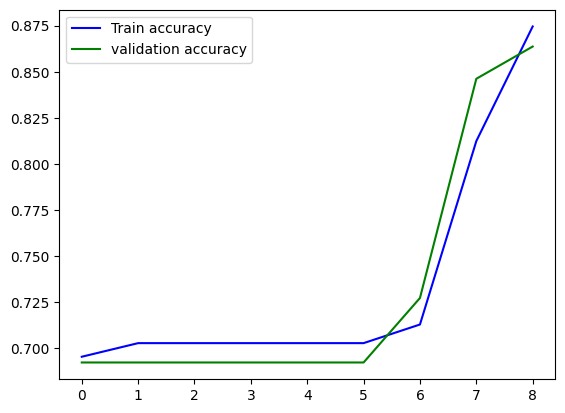

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'],color='blue',label='Train accuracy')
plt.plot(history.history['val_accuracy'],color='green',label='validation accuracy')
plt.legend()
plt.show()

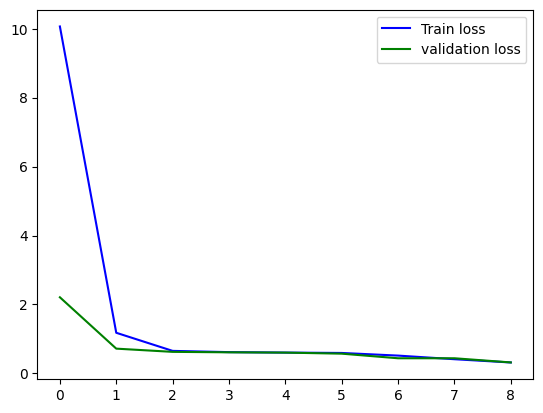

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],color='blue',label='Train loss')
plt.plot(history.history['val_loss'],color='green',label='validation loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import f1_score


val_preds_probs = multimodal_model.predict(val_multimodal_ds)
val_preds = (val_preds_probs > 0.5).astype(int).flatten()

y_val_true = labels[train_count:]

macro_f1 = f1_score(y_val_true, val_preds, average='macro')
print("Validation Macro F1 Score:", macro_f1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 992ms/step
Validation Macro F1 Score: 0.8146775881834948


In [ ]:
import pandas as pd
import os

test_df = pd.read_csv("/content/PoliMemeDecode/Test/Test.csv")
test_dir = "/content/PoliMemeDecode/Test/Image/"


test_df["filepath"] = test_df["Image_name"].apply(
    lambda x: os.path.join(test_dir, x)
)


In [ ]:

reader = easyocr.Reader(['bn','en'])

texts_test = []
for path in test_df["filepath"]:
    result = reader.readtext(path, detail=0)
    text = " ".join(result)
    texts_test.append(text)

test_df["ocr_text"] = texts_test


In [ ]:
IMG_SIZE = (224, 224)

def load_image_only(path):
    img = tensorflow.io.read_file(path)
    img = tensorflow.image.decode_jpeg(img, channels=3)
    img = tensorflow.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img


image_paths = test_df["filepath"].values
text_data = test_df["ocr_text"].values

image_array = np.array([load_image_only(p).numpy() for p in image_paths])
text_array = np.array([vectorizer([t]).numpy()[0] for t in text_data])


y_pred_probs = multimodal_model.predict([image_array, text_array])
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    "Image_name": test_df["Image_name"],
    "Label": y_pred
})

label_map_reverse = {1: "Political", 0: "NonPolitical"}
submission["Label"] = submission["Label"].map(label_map_reverse)

submission.to_csv("submission.csv", index=False)


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
